In [ ]:
# @title Conectare la drive
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import matplotlib.pyplot as plt

# Dataset

In [ ]:
# @title Path-uri

train_img_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/train/img/cls"
train_bin_mask_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/train/bin_mask/cls"
train_mult_mask_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/train/mult_mask/cls"

validation_img_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/validation/img/cls"
validation_bin_mask_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/validation/bin_mask/cls"
validation_mult_mask_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/validation/mult_mask/cls"

test_img_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/test/img/cls"
test_mask_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/test/mult_mask/cls"

In [ ]:
# @title Incarcam path-urile

def load_paths(imd_dir, mask_dir):
  image_paths = sorted([os.path.join(imd_dir, file_name) for file_name in os.listdir(imd_dir) if file_name.endswith(".tif")])
  mask_paths = sorted([os.path.join(mask_dir, file_name) for file_name in os.listdir(mask_dir) if file_name.endswith(".tif")])
  return image_paths, mask_paths

train_img_paths, train_mask_paths = load_paths(train_img_path, train_mult_mask_path)

validation_img_paths, validation_mask_paths = load_paths(validation_img_path, validation_mult_mask_path)

test_imgs_paths, test_masks_paths = load_paths(test_img_path, test_mask_path)

In [ ]:
# @title Augumentare data (Improved)

def augment_data(image, mask):
  # Convert to float for augmentations
  image = tf.cast(image, tf.float32)
  mask = tf.cast(mask, tf.float32) # Keep mask as float for transformations

  # Random flip orizontal (higher probability)
  if tf.random.uniform(()) > 0.3: # Increased chance of flipping
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)

  # Random flip vertical (higher probability)
  if tf.random.uniform(()) > 0.3: # Increased chance of flipping
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)

  # Random brightness (more range)
  if tf.random.uniform(()) > 0.4:
    image = tf.image.random_brightness(image, max_delta=0.3) # Increased max_delta

  # Random contrast (more range)
  if tf.random.uniform(()) > 0.4:
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3) # Increased range

  # Random rotation (still 90-degree steps as per tf.image.rot90)
  if tf.random.uniform(()) > 0.4:
      angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
      image = tf.image.rot90(image, angle)
      mask = tf.image.rot90(mask, angle)

  # Random Gaussian Noise (only applied to the image)
  if tf.random.uniform(()) > 0.5:
      noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32) # Experiment with stddev
      image = image + noise
      image = tf.clip_by_value(image, -1.0, 1.0) # Clip to maintain normalization range

  return image, mask


In [ ]:
# @title Preprocesare imagine + masca

def load_tif_with_pil(path):
  img = Image.open(path.numpy().decode('utf-8'))
  img = img.convert('L') # Convertim la grayscale
  img = np.array(img, dtype=np.float32)
  return img

def preprocess_mult(img_path, mask_path):
  img = tf.py_function(load_tif_with_pil, [img_path], tf.float32)
  img = tf.expand_dims(img, axis=-1)
  img.set_shape([None, None, 1])
  img = tf.image.resize(img, (256, 256))
  img = (img / 255.0) * 2.0 - 1.0 # Normalizare in intervalul [-1, 1]

  # Convertim grayscale -> RGB prin replicarea canalului
  img = tf.tile(img, [1, 1, 3])
  img.set_shape([256, 256, 3])

  mask = tf.py_function(load_tif_with_pil, [mask_path], tf.float32)
  mask = tf.expand_dims(mask, axis=-1)
  mask.set_shape([None, None, 1])
  mask = tf.image.resize(mask, (256, 256), method='nearest')
  mask = tf.squeeze(mask, axis=-1)          # Scoatem dimensiunea suplimentară
  mask = tf.cast(mask, tf.uint8)
  mask = tf.one_hot(mask, depth=8)           # Convertim la one-hot (8 clase)
  mask = tf.cast(mask, tf.float32)           # TensorFlow vrea float pentru loss

  # Setam shape explicit ca in paper
  # img.set_shape([256, 256, 1])
  mask.set_shape([256, 256, 8])

  return img, mask


In [ ]:
# @title Creare Dataset

def create_dataset(img_paths, mask_paths, batch_size=8, shuffle=True, augment=False):
  dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
  dataset = dataset.map(preprocess_mult, num_parallel_calls=tf.data.AUTOTUNE)

  if shuffle:
    dataset = dataset.shuffle(buffer_size=100)

  if augment:
    dataset = dataset.map(lambda img, mask: augment_data(img, mask), num_parallel_calls=tf.data.AUTOTUNE)

  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset


# Recreate the training dataset with augment=True
train_dataset = create_dataset(train_img_paths, train_mask_paths, batch_size=8, augment=True)

validation_dataset = create_dataset(validation_img_paths, validation_mask_paths, batch_size=8, shuffle=False, augment=False) # Augmentation only on train

test_dataset = create_dataset(test_imgs_paths, test_masks_paths, batch_size=8, shuffle=False, augment=False) # Augmentation only on train

print("\nDatasets recreated with enhanced augmentation.")
print(train_dataset.cardinality().numpy())
print(validation_dataset.cardinality().numpy())
print(test_dataset.cardinality().numpy())


Datasets recreated with enhanced augmentation.
13
13
13


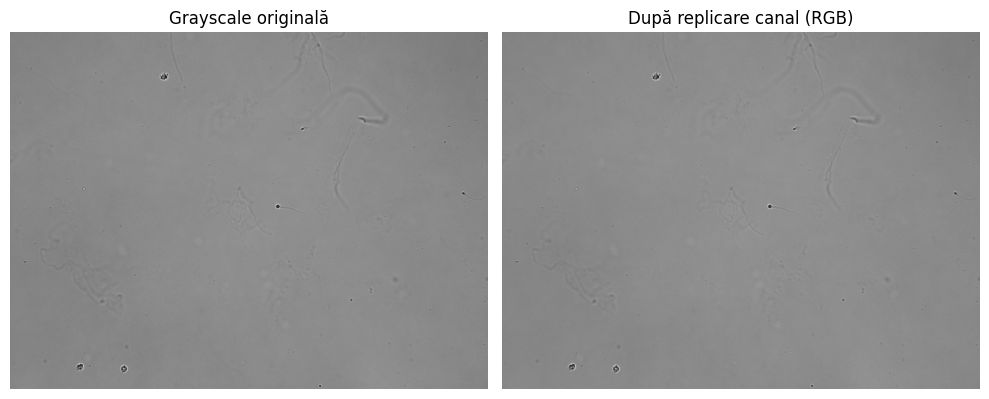

In [ ]:
# Încarcă imaginea grayscale
def load_grayscale_image(path):
  img = Image.open(path)
  img = img.convert('L')                      # grayscale
  img = np.array(img, dtype=np.float32)       # (H, W)
  img = (img / 255.0) * 2.0 - 1.0              # normalize [-1, 1]
  img = np.expand_dims(img, axis=-1)          # (H, W, 1)
  return img

# Transformare în RGB (replicare canal)
def convert_grayscale_to_rgb(img):
  return np.repeat(img, repeats=3, axis=-1)   # (H, W, 3)

# Exemplu
img_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/train/img/cls/0014.tif"  # Înlocuiește cu calea reală
img_gray = load_grayscale_image(img_path)
img_rgb = convert_grayscale_to_rgb(img_gray)

# Afișare
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow((img_gray.squeeze() + 1) / 2, cmap='gray')  # reconvertim la [0, 1]
plt.title("Grayscale originală")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow((img_rgb + 1) / 2)  # RGB normalizat la [0, 1]
plt.title("După replicare canal (RGB)")
plt.axis("off")

plt.tight_layout()
plt.show()

# DeepLabV3+

In [ ]:
from tqdm import tqdm

def get_image_paths_with_class(class_index, mask_paths):
  selected_paths = []
  for path in tqdm(mask_paths):
    mask = Image.open(path).convert('L')
    mask = np.array(mask)
    if class_index in mask:
      selected_paths.append(path)
  return selected_paths

# Ex: pentru clasa 1 (WBC/RBC)
mask_paths_with_class_1 = get_image_paths_with_class(1, train_mask_paths)

100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


In [ ]:
from PIL import Image
import numpy as np
from tqdm import tqdm

# Clasele ignorate
target_classes = {1, 3, 4, 6, 7}

# Funcție: returnează path-urile de imagine + mască unde apar aceste clase
def get_subset_paths(img_paths, mask_paths, target_classes):
  selected_img_paths = []
  selected_mask_paths = []

  for img_path, mask_path in tqdm(zip(img_paths, mask_paths), total=len(mask_paths)):
    mask = Image.open(mask_path).convert('L')
    mask_np = np.array(mask)
    if any(cls in mask_np for cls in target_classes):
      selected_img_paths.append(img_path)
      selected_mask_paths.append(mask_path)

  return selected_img_paths, selected_mask_paths

# Apel:
img_subset_paths, mask_subset_paths = get_subset_paths(train_img_paths, train_mask_paths, target_classes)

# Dataset cu doar exemplele care conțin clasele ignorate
finetune_dataset = create_dataset(
  img_subset_paths,
  mask_subset_paths,
  batch_size=4,  # batch mic pentru fine-tuning
  shuffle=True,
  augment=True
)

100%|██████████| 100/100 [00:00<00:00, 172.70it/s]


In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
  union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
  dice = (2. * intersection + smooth) / (union + intersection + smooth) # Corrected denominator for Dice Coefficient
  return tf.reduce_mean(dice)

def dice_loss(y_true, y_pred, smooth=1e-6):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
  union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
  dice = (2. * intersection + smooth) / (union + smooth)
  return  1 -tf.reduce_mean(dice)

def combined_focal_dice(gamma=2.0, alpha=0.25):
  def loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

    # Focal Loss
    ce = -y_true * tf.math.log(y_pred)
    weight = alpha * tf.math.pow(1 - y_pred, gamma)
    focal = tf.reduce_sum(weight * ce, axis=-1)
    focal = tf.reduce_mean(focal)

    # Dice Loss
    dice = dice_loss(y_true, y_pred)

    return focal + dice
  return loss

def focal_loss(class_weights, gamma=2.0):
  class_weights = tf.constant(class_weights, dtype=tf.float32)

  def loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = class_weights * y_true
    focal = tf.math.pow(1 - y_pred, gamma) * cross_entropy * weight
    return tf.reduce_mean(tf.reduce_sum(focal, axis=-1))  # medie pe batch.
  return loss

def multiclass_dice_loss():
  def loss(y_true, y_pred, smooth=1e-6):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)
  return loss

def combined_loss(class_weights, gamma=2.0, weight_dice=1.0):
  focal_fn = focal_loss(class_weights, gamma)
  dice_fn = multiclass_dice_loss()
  def loss(y_true, y_pred):
    return focal_fn(y_true, y_pred) + weight_dice * dice_fn(y_true, y_pred)
  return loss

In [ ]:
total_pixels = sum([1697, 1056, 41, 550, 182, 26, 10, 3562])
class_counts = np.array([3562, 1697, 1056, 41, 550, 182, 26, 10]) # Order matters!
# Ensure the order of class counts corresponds to your class indices (0 to 7)

num_classes = 8
class_weights = total_pixels / (class_counts * num_classes)
class_weights = class_weights / np.sum(class_weights) * num_classes # Normalize weights

print("Calculated Class Weights:", class_weights)

# Modify your combined_focal_dice loss to incorporate weights
def weighted_combined_focal_dice(class_weights, gamma=2.0, alpha=0.25):
  def loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

    # Apply weights to y_true for loss calculation
    y_true_weighted = y_true * class_weights

    # Focal Loss (applied to weighted true)
    ce = -y_true_weighted * tf.math.log(y_pred) # Use weighted true here
    weight = alpha * tf.math.pow(1 - y_pred, gamma)
    focal = tf.reduce_sum(weight * ce, axis=-1)
    focal = tf.reduce_mean(focal)

    # Dice Loss (standard Dice calculation is often sufficient)
    # If you want to weight Dice, it's a bit more complex, focusing on weighted intersection and union
    # For simplicity, let's use the standard Dice for now, as Focal Loss will help with rare classes.
    dice = dice_loss(y_true, y_pred) # Standard Dice Loss

    return focal + dice
  return loss

Calculated Class Weights: [0.01305914 0.0274111  0.04404985 1.13455227 0.08457571 0.25558595
 1.78910166 4.65166431]


In [ ]:
def DeepLabV3Plus(input_shape=(256, 256, 3), n_classes=8, l2_lambda=0.0001):
  base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

  # ASPP
  x = base_model.output

  # Image Pooling branch (b4)
  b4 = layers.GlobalAveragePooling2D()(x)
  b4 = layers.Reshape((1, 1, -1))(b4)
  b4 = layers.Conv2D(256, 1, padding='same', use_bias=False,
                     kernel_regularizer=regularizers.l2(l2_lambda))(b4) # Added regularization
  b4 = layers.BatchNormalization()(b4)
  b4 = layers.Activation('relu')(b4)
  # Upsampling to match 'x' size before concatenation for ASPP
  # Note: This upsampling is within the ASPP block, not for the final concatenation with skip connection.
  # The shape of 'x' here is typically reduced from the initial input, e.g., 32x32.
  # The b4 branch output needs to be upsampled to match this 'x' spatial dimension (e.g., 32x32).
  # Let's use the shape of 'x' to determine the correct upsampling factor.
  b4 = layers.UpSampling2D(size=(x.shape[1] // b4.shape[1], x.shape[2] // b4.shape[2]), interpolation='bilinear')(b4)


  # 1x1 Convolution branch (b0) - Corrected initialization
  b0 = layers.Conv2D(256, 1, padding='same', use_bias=False,
                     kernel_regularizer=regularizers.l2(l2_lambda))(x) # Apply to 'x' first
  b0 = layers.BatchNormalization()(b0)
  b0 = layers.Activation('relu')(b0)

  # Dilated Convolution branches (b1, b2, b3)
  b1 = layers.Conv2D(256, 3, dilation_rate=6, padding='same', use_bias=False,
                     kernel_regularizer=regularizers.l2(l2_lambda))(x) # Added regularization
  b1 = layers.BatchNormalization()(b1)
  b1 = layers.Activation('relu')(b1)

  b2 = layers.Conv2D(256, 3, dilation_rate=12, padding='same', use_bias=False,
                     kernel_regularizer=regularizers.l2(l2_lambda))(x) # Added regularization
  b2 = layers.BatchNormalization()(b2)
  b2 = layers.Activation('relu')(b2)

  b3 = layers.Conv2D(256, 3, dilation_rate=18, padding='same', use_bias=False,
                     kernel_regularizer=regularizers.l2(l2_lambda))(x) # Added regularization
  b3 = layers.BatchNormalization()(b3)
  b3 = layers.Activation('relu')(b3)

  # Concatenate ASPP branches
  x = layers.Concatenate()([b4, b0, b1, b2, b3])
  x = layers.Conv2D(256, 1, padding='same', use_bias=False,
                    kernel_regularizer=regularizers.l2(l2_lambda))(x) # Added regularization
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  # Upsampling the ASPP output to match the spatial dimensions of the low-level skip connection
  # Based on the error, the target size is likely (63, 63) for the skip connection from Xception's block3.
  # Let's check the actual output shape of the target layer.
  # However, based on the structure, the intent was likely to upsample to a specific size
  # like (64, 64) or the original input size / 4.
  # Let's assume the target for concatenation is (64, 64) as indicated by the original code's comment
  # about resizing skip1 to 64x64.
  target_h, target_w = 64, 64
  x = layers.UpSampling2D(size=(target_h // x.shape[1], target_w // x.shape[2]), interpolation='bilinear')(x)


  # Skip connection from the lower level (block3_sepconv2_bn)
  skip1 = base_model.get_layer("block3_sepconv2_bn").output
  skip1 = layers.Conv2D(48, 1, padding='same', use_bias=False,
                        kernel_regularizer=regularizers.l2(l2_lambda))(skip1) # Added regularization
  skip1 = layers.BatchNormalization()(skip1)
  skip1 = layers.Activation('relu')(skip1)

  # Explicitly resize the skip connection to the target size for concatenation
  # This handles cases where the base model output isn't exactly the desired size (e.g., 63x63 instead of 64x64)
  skip1 = layers.Resizing(target_h, target_w, interpolation='bilinear')(skip1)

  # Concatenate x and skip1 - they should now have the same spatial dimensions (64, 64)
  x = layers.Concatenate()([x, skip1])

  # Decoder path
  x = layers.Conv2D(256, 3, padding='same', use_bias=False,
                    kernel_regularizer=regularizers.l2(l2_lambda))(x) # Added regularization
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(256, 3, padding='same', use_bias=False,
                    kernel_regularizer=regularizers.l2(l2_lambda))(x) # Added regularization
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  # Final Upsampling to the original input size (256, 256)
  # Ensure the upsampling factor is calculated correctly based on the current size of x
  x = layers.UpSampling2D(size=(input_shape[0] // x.shape[1], input_shape[1] // x.shape[2]), interpolation='bilinear')(x)


  output = layers.Conv2D(n_classes, 1, padding='same', activation='softmax')(x)
  return Model(inputs=base_model.input, outputs=output)

In [ ]:
# model = tf.keras.models.load_model("deeplabv3plus_urinary_cells.h5", custom_objects={'dice_loss': dice_loss, 'combined_focal_dice': combined_focal_dice})
model = DeepLabV3Plus(l2_lambda=0.0001) # You can experiment with different lambda values

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate,
  decay_steps=100000,
  decay_rate=0.9,
  staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

class_weights = [1, 20, 5, 15, 10, 1, 5, 15]

model.compile(
      optimizer=optimizer,
      loss="categorical_crossentropy",
      #loss=combined_loss(class_weights, gamma=2.0, weight_dice=1.0),
      metrics=[MeanIoU(num_classes=8), dice_coefficient]
    )

In [ ]:
# # Add a callback to print the learning rate per epoch
# class LearningRateLogger(tf.keras.callbacks.Callback):
#     def __init__(self, lr_schedule):
#         super().__init__()
#         self.lr_schedule = lr_schedule # Store the scheduler object

#     def on_epoch_end(self, epoch, logs=None):
#         # Call the scheduler object with the current step (optimizer.iterations)
#         lr = self.lr_schedule(self.model.optimizer.iterations).numpy()
#         print(f"Epoch {epoch + 1}: Learning Rate = {lr:.6f}")

# # Define an Early Stopping callback
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_mean_io_u_3', # Monitor the validation mean IoU
#     patience=10,           # Number of epochs with no improvement after which training will be stopped.
#     mode='max',            # Stop when the monitored quantity has maximized
#     restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
# )

# # Instantiate the LearningRateLogger with the actual lr_schedule object
# lr_logger = LearningRateLogger(lr_schedule)


# Train the model with the Early Stopping and Learning Rate Logger callbacks
history = model.fit( # Capture the training history
  train_dataset,
  validation_data=validation_dataset,
  epochs=100, # Set a relatively large number of epochs
)

# # Plot training and validation loss and IoU
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['mean_io_u_3'], label='Training Mean IoU')
# plt.plot(history.history['val_mean_io_u_3'], label='Validation Mean IoU')
# plt.title('Mean IoU over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Mean IoU')
# plt.legend()

# plt.tight_layout()
# plt.show()

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - dice_coefficient: 0.3226 - loss: 1.6275 - mean_io_u_3: 0.4375 - val_dice_coefficient: 0.0325 - val_loss: 13.0522 - val_mean_io_u_3: 0.4375
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 623ms/step - dice_coefficient: 0.6162 - loss: 0.4273 - mean_io_u_3: 0.4375 - val_dice_coefficient: 0.2341 - val_loss: 3.1204 - val_mean_io_u_3: 0.4375
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 640ms/step - dice_coefficient: 0.6459 - loss: 0.3420 - mean_io_u_3: 0.4375 - val_dice_coefficient: 0.4351 - val_loss: 1.5826 - val_mean_io_u_3: 0.4375
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 621ms/step - dice_coefficient: 0.6529 - loss: 0.3171 - mean_io_u_3: 0.4375 - val_dice_coefficient: 0.5641 - val_loss: 0.6132 - val_mean_io_u_3: 0.4375
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 640ms/step - dice_coefficient: 0.6533 - loss: 0.3126 - mean_io_u_3: 0.4375 - val_dice_coefficient: 0.6216 - val_loss: 0.3872 - val_mean_io_u_3: 0.4375
Epoch 6/100
13/13 ━━━━━━━━━━━━━━

In [ ]:
# model.save("deeplabv3plus.keras")


results = model.evaluate(test_dataset)
print("test loss, test acc:", results)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - dice_coefficient: 0.6589 - loss: 0.0701 - mean_io_u_3: 0.4550
test loss, test acc: [0.07684489339590073, 0.4537802040576935, 0.6580039262771606]


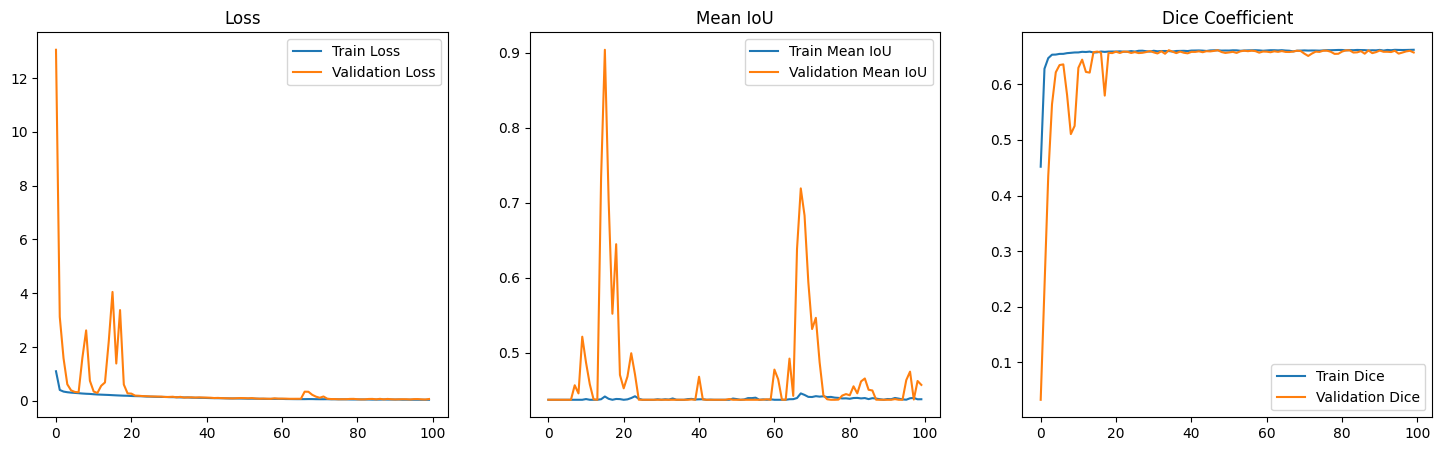

In [ ]:
# Salvare model
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5)) # Increased figure size to accommodate more plots

plt.subplot(1,3,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(history.history['mean_io_u_3'], label='Train Mean IoU') # Use the metric name added in compile
plt.plot(history.history['val_mean_io_u_3'], label='Validation Mean IoU') # Use the metric name added in compile
plt.title('Mean IoU')
plt.legend()

plt.subplot(1,3,3)
plt.plot(history.history['dice_coefficient'], label='Train Dice') # Use the metric name added in compile
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice') # Use the metric name added in compile
plt.title('Dice Coefficient')
plt.legend()

plt.show()

In [ ]:
def calculate_dice_per_class(model, dataset, num_classes=8, smooth=1e-6):
  intersection = np.zeros(num_classes)
  union = np.zeros(num_classes)

  for img_batch, mask_batch in dataset:
    preds = model.predict(img_batch)
    preds = np.argmax(preds, axis=-1)
    masks = np.argmax(mask_batch.numpy(), axis=-1)

    for cls in range(num_classes):
      pred_cls = (preds == cls).astype(np.float32)
      mask_cls = (masks == cls).astype(np.float32)

      intersection[cls] += np.sum(pred_cls * mask_cls)
      union[cls] += np.sum(pred_cls) + np.sum(mask_cls)

  dice_per_class = (2. * intersection + smooth) / (union + smooth)

  print("=== Dice Score per clasă ===")
  for i, score in enumerate(dice_per_class):
    print(f"Clasă {i}: {score:.4f}")

  return dice_per_class

# Apelează funcția
dice_scores = calculate_dice_per_class(model, test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
=== Dice Score per clasă ===
Clasă 0: 0.9954
Clasă 1: 0.0000
Clasă 2: 0.2069
Clasă 3: 0.0000
Clasă 4: 0.0000
Clasă 5: 0.6132
Clasă 6: 0.0445
Clasă 7: 0.1041


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


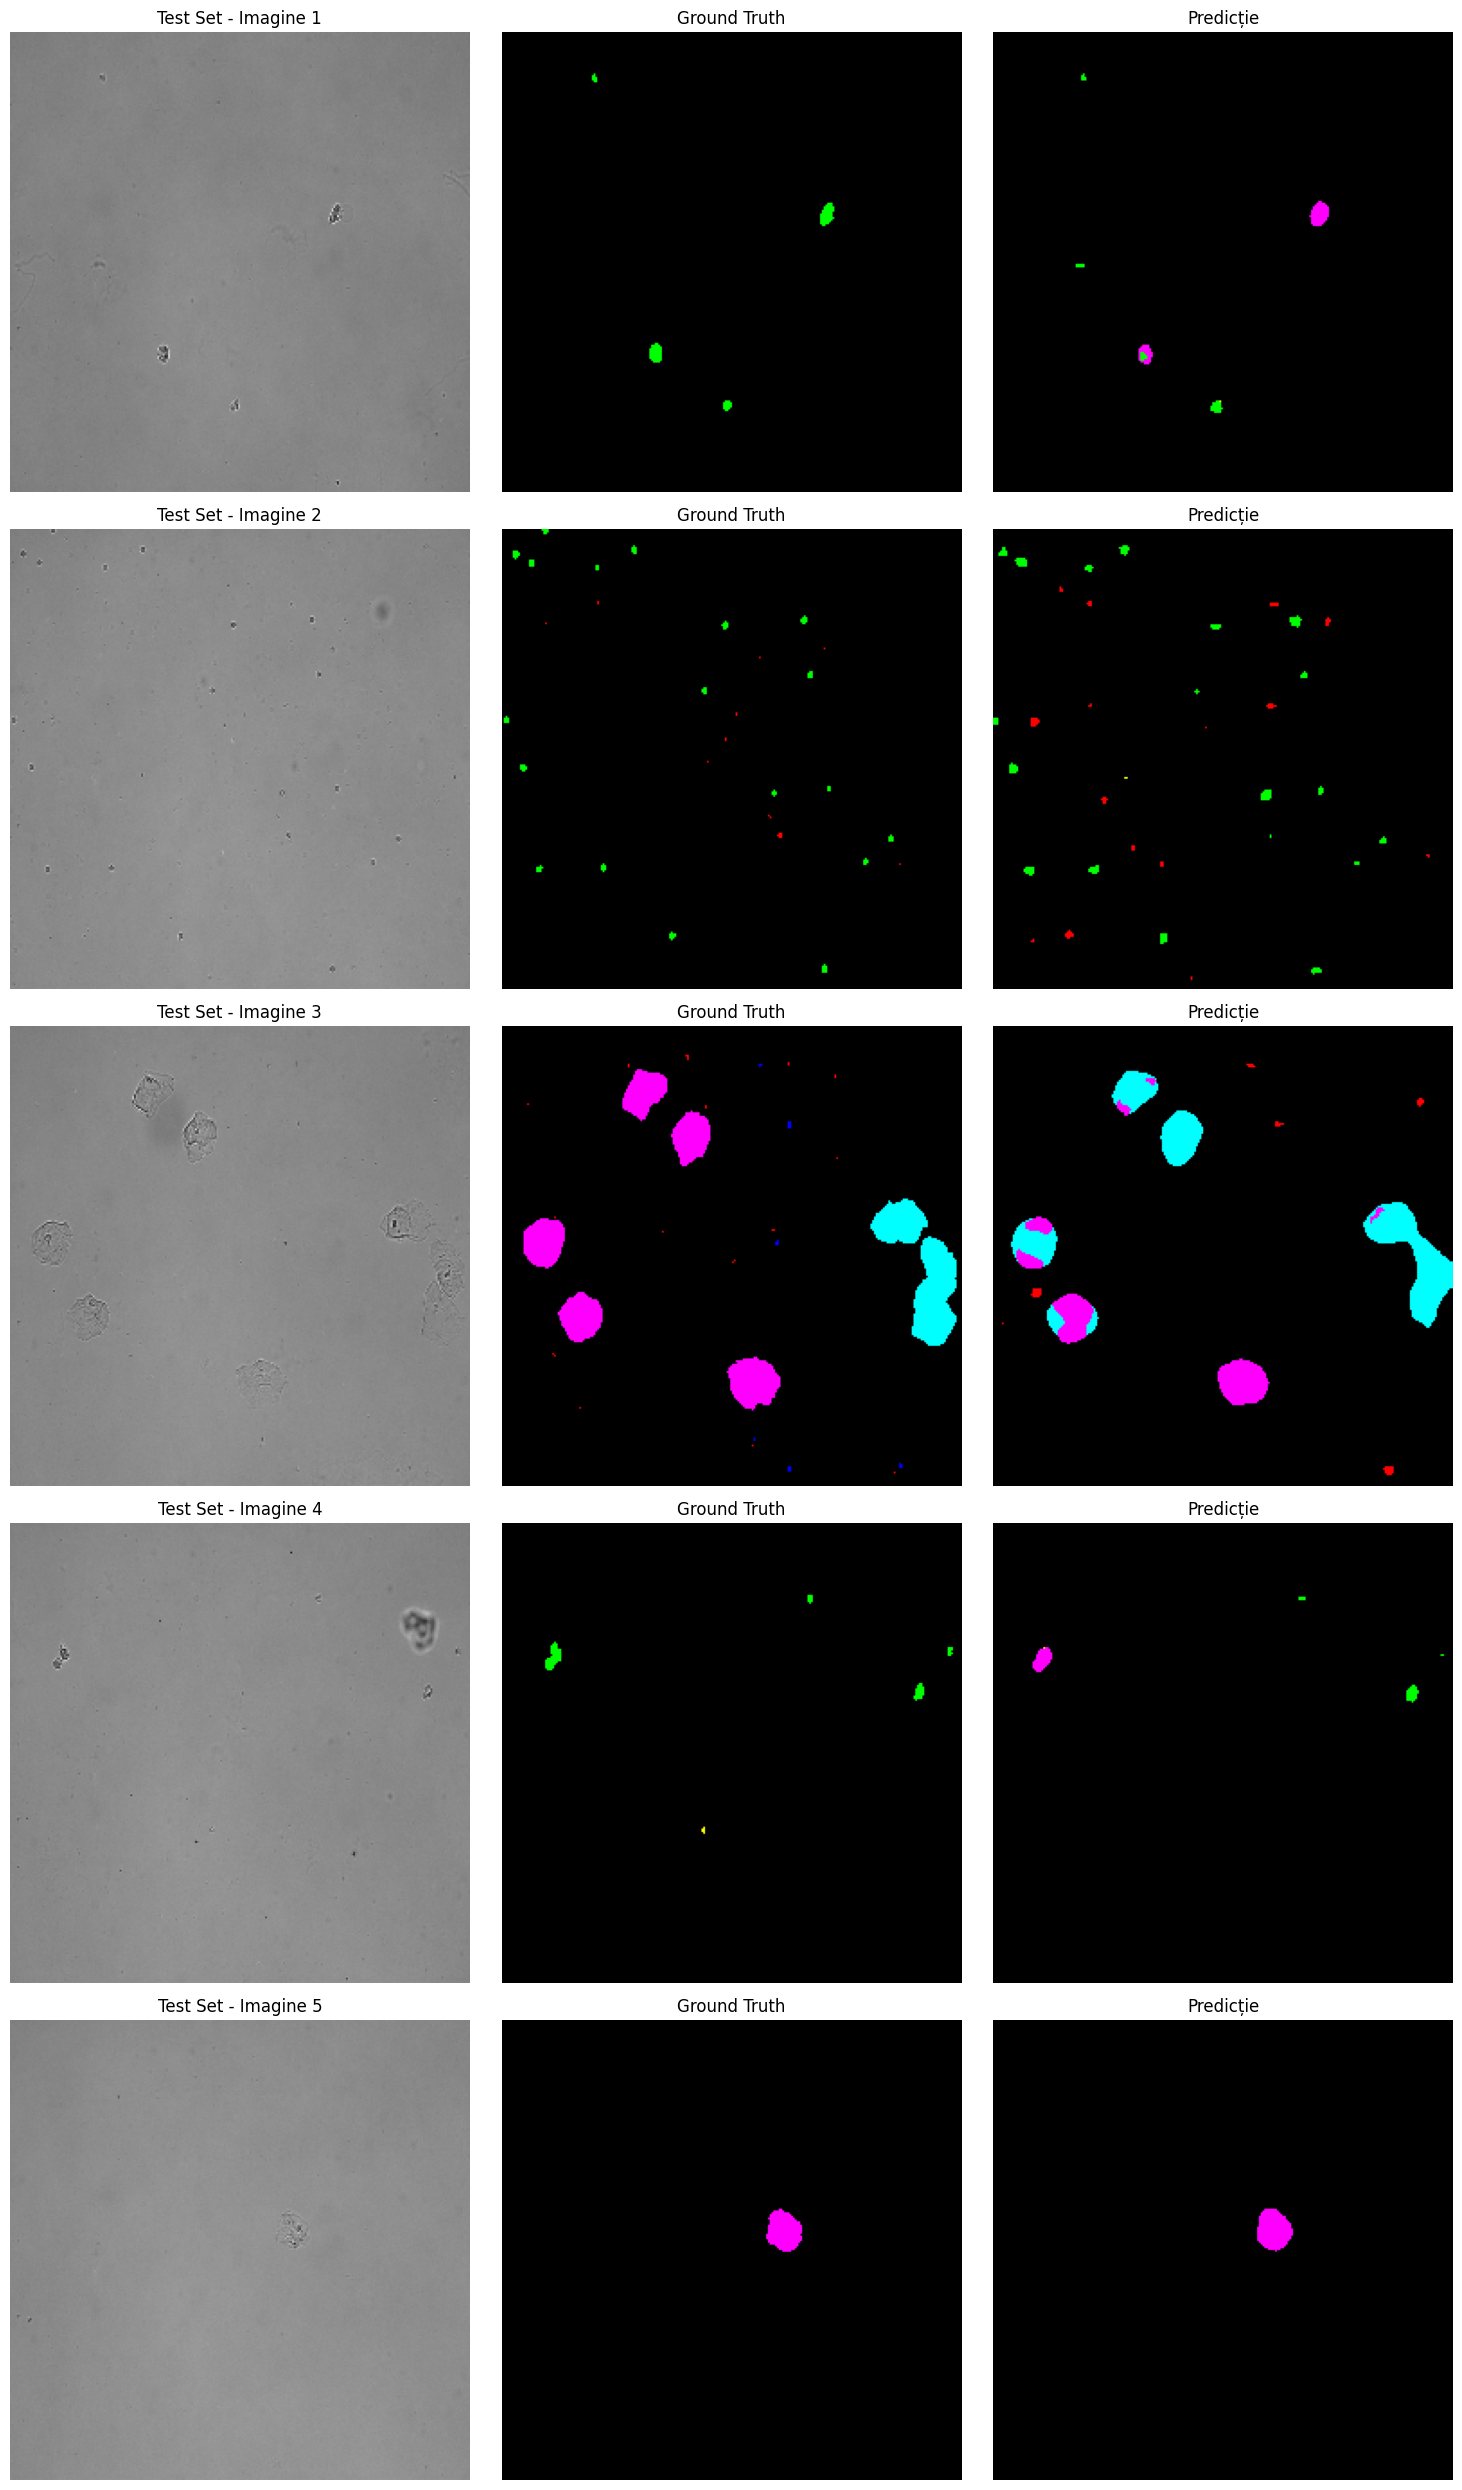

In [ ]:
import matplotlib.pyplot as plt

# Culori RGB pentru cele 8 clase
clase_culori = np.array([
    [0, 0, 0],       # 0 - Background
    [255, 0, 0],     # 1 - Rod
    [0, 255, 0],     # 2 - RBC/WBC
    [0, 0, 255],     # 3 - Yeast
    [255, 255, 0],   # 4 - Misc
    [255, 0, 255],   # 5 - Single EPC
    [0, 255, 255],   # 6 - Small EPC sheet
    [255, 165, 0]    # 7 - Large EPC sheet
], dtype=np.uint8)

def decode_mask(mask_one_hot):
  mask_labels = np.argmax(mask_one_hot, axis=-1)
  return clase_culori[mask_labels]

def vizualizeaza_predictii(model, dataset, nume_dataset="Test Set", nume_model="Model", nume_pred="Predicție", n=5):
  fig, axes = plt.subplots(n, 3, figsize=(15, 5 * n))
  for i, (img_batch, mask_batch) in enumerate(dataset.take(n)):
    img = img_batch[0].numpy()
    mask_true = mask_batch[0].numpy()

    pred = model.predict(np.expand_dims(img, axis=0))[0]
    img_display = ((img + 1) / 2).squeeze()

    mask_true_rgb = decode_mask(mask_true)
    mask_pred_rgb = decode_mask(pred)

    axes[i, 0].imshow(img_display, cmap='gray')
    axes[i, 0].set_title(f"{nume_dataset} - Imagine {i+1}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask_true_rgb)
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(mask_pred_rgb)
    axes[i, 2].set_title(nume_pred)
    axes[i, 2].axis('off')

  plt.tight_layout()
  plt.show()

# Apelează funcția
vizualizeaza_predictii(model, test_dataset, n=5)

# Fine Tunning

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix

num_classes = 8

# Colectăm toate valorile
y_true_all = []
y_pred_all = []

for img_batch, mask_batch in test_dataset:
  pred_batch = model.predict(img_batch)
  y_pred = tf.argmax(pred_batch, axis=-1).numpy().flatten()
  y_true = tf.argmax(mask_batch, axis=-1).numpy().flatten()
  y_pred_all.extend(y_pred)
  y_true_all.extend(y_true)

# Confusion matrix
conf_mat = confusion_matrix(y_true_all, y_pred_all, labels=list(range(num_classes)))

# Calcul IoU pe fiecare clasă
ious = []
for i in range(num_classes):
  tp = conf_mat[i, i]
  fn = np.sum(conf_mat[i, :]) - tp
  fp = np.sum(conf_mat[:, i]) - tp
  denom = tp + fp + fn
  iou = tp / denom if denom != 0 else 0.0
  ious.append(iou)

# Afișare
for i, iou in enumerate(ious):
  print(f"Clasa {i}: IoU = {iou:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Clasa 0: IoU = 0.9901
Clasa 1: IoU = 0.0000
Clasa 2: IoU = 0.1803
Clasa 3: IoU = 0.0000
Clasa 4: IoU = 0.0000
Clasa 5: IoU = 0.4655
Clasa 6: IoU = 0.0343
Clasa 7: IoU = 0.0895
